# Description

This notebook is used to tabulate final results and compare novel generated molecules vs HIV inhibitors vs Remdesivir which entered clinical trials just a few days ago.

## Now the best results and save to sdf for last double check tabulation in PyRx

In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
import random
import numpy as np
import rdkit.Chem.PropertyMol

In [128]:
# './generations/master_results_table_gen10.csv'

final = pd.read_csv('./generations/master_results_table_gen11.csv',sep=',')
final = final.sort_values('score', ascending=True)
print(final.shape)
final.head()

(12097, 7)


,id,gen,smile,source,weight,logp,score
0,ABZJ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1312.235,32.3335,-16.0
1,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6
2,ABJD,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1384.386,34.3280,-15.6
3,ACIQ,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,generated,1290.229,32.4477,-15.6
4,ABIN,11,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1394.466,35.8504,-15.5


In [129]:
final_max = final.groupby("smile").max()[["score","gen"]].reset_index()
final_max = final_max.sort_values('score', ascending=True)
print(final_max.shape)
final_max.head()

(12045, 3)


,smile,score,gen
6632,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-16.0,11
6408,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCC2CCCCCCCCCCCC...,-15.6,11
6661,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.6,11
6634,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.6,10
6599,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,-15.5,11


In [18]:
final_joined = pd.merge(final_max, final, on=['smile','gen'], suffixes=('_old','_new'), how='left')

# final_joined = final_joined[(final_joined['score_new'] <= -15.0) & (final_joined['weight'] < 900)]
final_joined = final_joined[(final_joined['score_new'] <= -12.0) & (final_joined['logp']<5)]

final_joined['score'] = final_joined['score_new']
final_joined = final_joined.drop('score_old', axis=1)
final_joined = final_joined.drop('score_new', axis=1)
print(final_joined.shape)
final_joined.head(30)

(2, 7)


,smile,gen,id,source,weight,logp,score
78,CC1CCC(C(=O)Nc2nnnn2N2CCN(C(=O)Nc3nnnnn3)C2=O)...,8,AACJ,generated,693.732,4.87440,-13.1
9356,CC=CC=CC#N,10,AABX,genetic_algorithm,93.129,1.64228,-12.2


In [14]:
final_table = final_joined.append(hiv)
final_table.head()

,smile,gen,id,source,weight,logp,score
0,CC1=CC=C(C)C(=O)NN2CCN3CC(=O)NC(C)C=CC=CC=C(C(...,4,AAHF,generated,717.823,4.08010,-11.2
1,CC1=CC=C2C(=O)OC(=O)C(Cc3ccccc3)NC(=O)C(C)=CCC...,2,AAXI,generated,753.856,4.87358,-11.2
2,CC1CCC(NN=C2CCCC=CC=C(NC(=O)c3ccccc3)OCCCCC=CC...,4,AAUE,generated,900.221,12.92120,-11.0


In [8]:
# Note I also manually added Remdesivir because as working on this it went into clinical trials
# https://en.wikipedia.org/wiki/Remdesivir

final_table.to_csv(r'./generations/master_results_table_final2.csv', index=False)

In [15]:
final_table = pd.read_csv('./generations/master_results_table_final.csv')
final_table.tail()

,smile,gen,id,source,weight,score_best,score_avg,similarity_to_hiv_inhibitors,similarity_to_remdesivir
50,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1CCOC1)S(=O)(...,0,ABSM,hiv,505.637,-7.7,-7.288889,0.558467,0.404068
51,CCCC1(CCc2ccccc2)CC(O)=C(C(CC)c2cccc(NS(=O)(=O...,0,ABSP,hiv,602.675,-7.6,-7.200000,0.493003,0.562334
52,O=C1Nc2ccc(Cl)cc2C(C#CC2CC2)(C(F)(F)F)O1,0,ABSQ,hiv,315.678,-6.4,-6.055556,0.433602,0.481928
53,CC(C)c1nc(CN(C)C(=O)NC(C(=O)NC(Cc2ccccc2)CC(O)...,0,ABSO,hiv,720.962,NaN,NaN,0.451159,0.476061
54,Cc1cccc(C)c1OCC(=O)NC(Cc1ccccc1)C(O)CC(Cc1cccc...,0,ABSJ,hiv,628.814,NaN,NaN,0.430199,0.422064


In [10]:
def set_molecule(row):
    mol = Chem.MolFromSmiles(row['smile'])
    pm = Chem.PropertyMol.PropertyMol(mol)
    title = 'id' + str(row['id']) + 'gen'+ str(row['gen'])
#     print(title)
    # Enables for tracking which molecule is which in PyRx GUI and PyRx results export
    pm.SetProp('Title', title)
    return pm

In [11]:
mols_for_export = final_table.apply(set_molecule, axis=1)
# list(mols_for_export)

In [12]:
w = Chem.SDWriter('./generations/genfinal.sdf')
for m in mols_for_export:
    w.write(m)

## Rerun everything through PyRx once more to double check, then publish final metrics

In [ ]:
new_scores = pd.read_csv('./generations/results/results_genfinal.csv',sep=',')
new_scores.head()

In [ ]:
new_scores = new_scores.groupby("Ligand").agg({'Binding Affinity': [np.min,np.average]}).reset_index()
new_scores.head()

In [ ]:
new_scores['id'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[0].str.split("id").str[1]
new_scores['gen'] = new_scores['Ligand'].str.split("_").str[1].str.split("gen").str[1]
new_scores['score_best'] = new_scores["Binding Affinity"]["amin"]
new_scores['score_avg'] = new_scores["Binding Affinity"]["average"]
new_scores = new_scores[['id','gen','score_best','score_avg']]
new_scores.head()

In [ ]:
new_scores.id = new_scores.id.astype(str)
new_scores.gen = new_scores.gen.astype(str)
final_table.id = final_table.id.astype(str)
final_table.gen = final_table.gen.astype(str)

In [ ]:
new_table = pd.merge(final_table, new_scores, on=['id','gen'], suffixes=('_old','_new'), how='left')
new_table['score_best'] = new_table[('score_best', '')]
new_table['score_avg'] = new_table[('score_avg', '')]
new_table = new_table.drop([('score_best', ''),('score_avg', '')], axis=1)
new_table = new_table.sort_values('score_best', ascending=True)
new_table.tail()

In [ ]:
new_table.columns

In [ ]:
hiv_smiles = new_table[(new_table['source'] == 'hiv') & (new_table['score_best'].notnull())]
hiv_smiles_list = list(hiv_smiles['smile'])
hiv_smiles.head(20)

In [ ]:
hiv_fingerprints = []
for smile in hiv_smiles_list:
    hiv_fingerprints.append(Chem.RDKFingerprint(Chem.MolFromSmiles(smile)))

def calc_hiv_similarity_score(row):
    fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles(row['smile']))
    similarity = np.mean(DataStructs.BulkTanimotoSimilarity(fingerprint,hiv_fingerprints))
    return similarity

remdesivir_fingerprint = Chem.RDKFingerprint(Chem.MolFromSmiles('CCC(CC)COC(=O)[C@H](C)NP(=O)(OC[C@H]1O[C@](C#N)([C@H](O)[C@@H]1O)C1=CC=C2N1N=CN=C2N)OC1=CC=CC=C1'))

new_table['similarity_to_hiv_inhibitors'] = new_table.apply(calc_hiv_similarity_score, axis=1)
new_table['similarity_to_remdesivir'] = new_table['smile'].apply(lambda x: DataStructs.TanimotoSimilarity(Chem.RDKFingerprint(Chem.MolFromSmiles(x)),remdesivir_fingerprint))
new_table.head(50)

In [ ]:
new_table.to_csv(r'./generations/master_results_table_final.csv', index=False)

# Data Visualization

In [28]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
final.describe()

,gen,weight,logp,score
count,10716.000000,10716.000000,10716.000000,10716.000000
mean,4.326428,356.050101,4.937298,0.791844
std,3.218532,294.366840,8.288639,27.250861
min,0.000000,18.015000,-9.704780,-15.600000
25%,1.000000,174.203000,1.410425,-7.400000
50%,4.000000,283.327000,2.476350,-6.100000
75%,7.000000,390.496250,4.124500,-4.800000
max,10.000000,1781.429000,49.564700,99.900000


In [30]:
final.columns

Index(['id', 'gen', 'smile', 'source', 'weight', 'logp', 'score'], dtype='object')

In [51]:
final.dropna()

,id,gen,smile,source,weight,logp,score
0,ABKL,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1264.191,31.4891,-15.6
1,ABDZ,9,CC1CCC(C(=O)Nc2nnnn2-c2nnnnn2)c2ccccc2-c2ccccc...,generated,871.021,11.9259,-15.3
2,AACR,7,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1204.051,29.6248,-15.2
3,ABEE,7,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1242.021,26.9575,-14.8
4,AAHU,10,CC1CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,generated,1286.197,32.5886,-14.6
...,...,...,...,...,...,...,...
10219,AAGU,1,CC(C)CN(CC(O)C(Cc1ccccc1)NC(=O)OC1COC2OCCC12)S...,generated,704.868,4.7498,99.9
10220,AAML,0,CC(=CCC1OC(C)(C)OC1=O)CCCC(C)(C)O,generated,270.369,2.9421,99.9
10221,AANK,1,COC(=O)NC(C(=O)O)C(CO)NC(=O)OC1COC2OCCC12,generated,348.308,-1.3559,99.9
10212,AAIW,1,CNC(=O)c1ccccc1C(=O)NC(C)(C)C(C)C,generated,262.353,2.2106,99.9


### Binding Score

<Figure size 576x432 with 0 Axes>

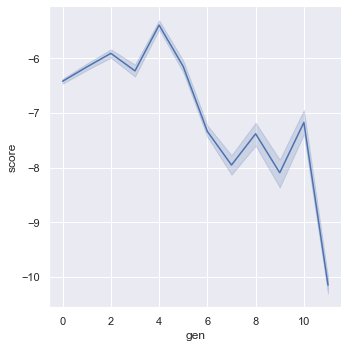

In [150]:
plt.figure(figsize=(8,6))
score = sns.relplot(x="gen", y="score", kind="line", data=final)

### Binding Score and logP

Text(0.5, 0, 'gen')

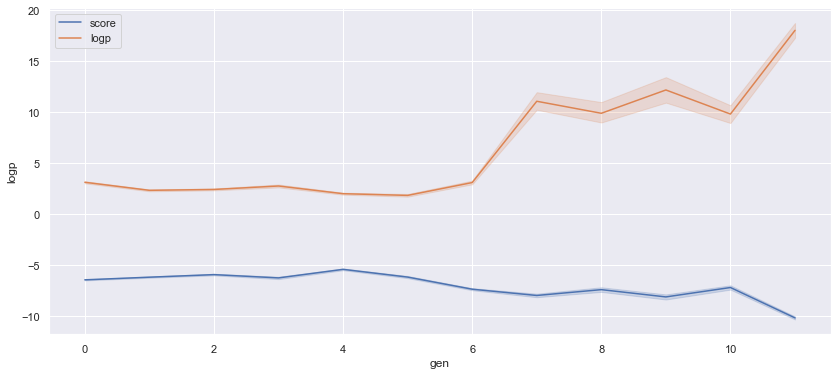

In [136]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

sns.lineplot(y=final['score'],x=final['gen'], label="score")
sns.lineplot(y=final['logp'],x=final['gen'], label="logp")

# Add label for horizontal axis
plt.xlabel("gen")


<Figure size 1008x432 with 0 Axes>

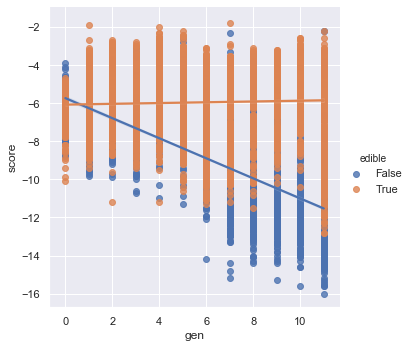

In [163]:
plt.figure(figsize=(14,6))
# final["edible"] = (final["logp"]<0)
final["edible"] = (final["logp"]<5) & (final["logp"]>0)
sns.lmplot(x="gen",y="score", data=final, hue="edible")

### Max, Mean, Min of score

Text(0.5, 0, 'gen')

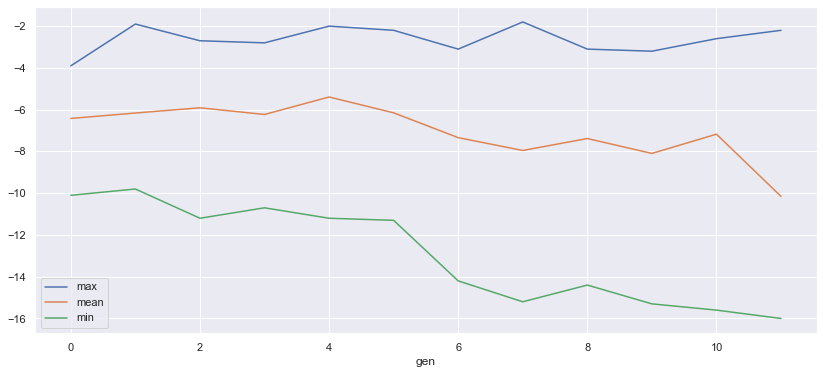

In [147]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

final.dropna()
final = final[final.score != 99.9]
final_max = final.groupby('gen')["score"].max()
final_min = final.groupby('gen')["score"].min()
final_mean = final.groupby('gen')['score'].mean()

sns.lineplot(data=final_max, label="max")
sns.lineplot(data=final_mean, label="mean")
sns.lineplot(data=final_min, label="min")

# Add label for horizontal axis
plt.xlabel("gen")

### Max, Mean and Min of logP

Text(0.5, 0, 'gen')

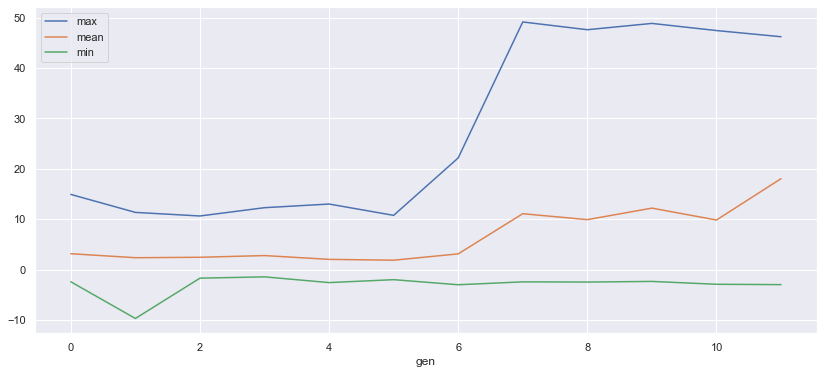

In [131]:
# Set the width and height of the figure
plt.figure(figsize=(14,6))

final.dropna()
final = final[final.score != 99.9]
logP_max = final.groupby('gen')["logp"].max()
logP_min = final.groupby('gen')["logp"].min()
logP_mean = final.groupby('gen')['logp'].mean()

sns.lineplot(data=logP_max, label="max")
sns.lineplot(data=logP_mean, label="mean")
sns.lineplot(data=logP_min, label="min")

# Add label for horizontal axis
plt.xlabel("gen")

### Gaussian of the logP

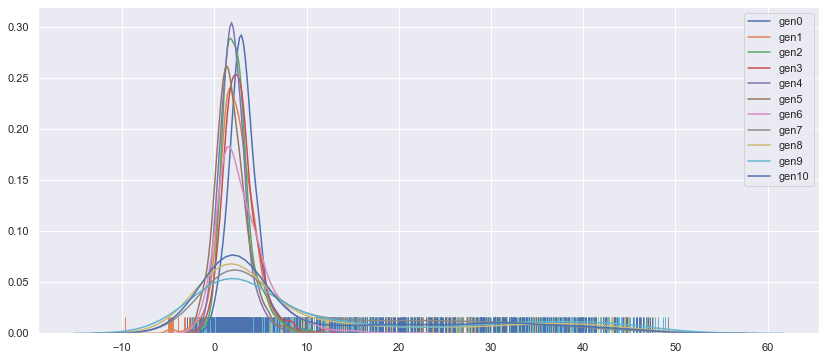

In [152]:
# Sort the dataframe by target
plt.figure(figsize=(14,6))

gen0_dist = final.loc[final['gen'] == 0]
gen1_dist = final.loc[final['gen'] == 1]
gen2_dist = final.loc[final['gen'] == 2]
gen3_dist = final.loc[final['gen'] == 3]
gen4_dist = final.loc[final['gen'] == 4]
gen5_dist = final.loc[final['gen'] == 5]
gen6_dist = final.loc[final['gen'] == 6]
gen7_dist = final.loc[final['gen'] == 7]
gen8_dist = final.loc[final['gen'] == 8]
gen9_dist = final.loc[final['gen'] == 9]
gen10_dist = final.loc[final['gen'] == 10]



sns.distplot(gen0_dist[['logp']], hist=False, rug=True, label="gen0")
sns.distplot(gen1_dist[['logp']], hist=False, rug=True, label="gen1")
sns.distplot(gen2_dist[['logp']], hist=False, rug=True, label="gen2")
sns.distplot(gen3_dist[['logp']], hist=False, rug=True, label="gen3")
sns.distplot(gen4_dist[['logp']], hist=False, rug=True, label="gen4")
sns.distplot(gen5_dist[['logp']], hist=False, rug=True, label="gen5")
sns.distplot(gen6_dist[['logp']], hist=False, rug=True, label="gen6")
sns.distplot(gen7_dist[['logp']], hist=False, rug=True, label="gen7")
sns.distplot(gen8_dist[['logp']], hist=False, rug=True, label="gen8")
sns.distplot(gen9_dist[['logp']], hist=False, rug=True, label="gen9")
sns.distplot(gen10_dist[['logp']], hist=False, rug=True, label="gen10")



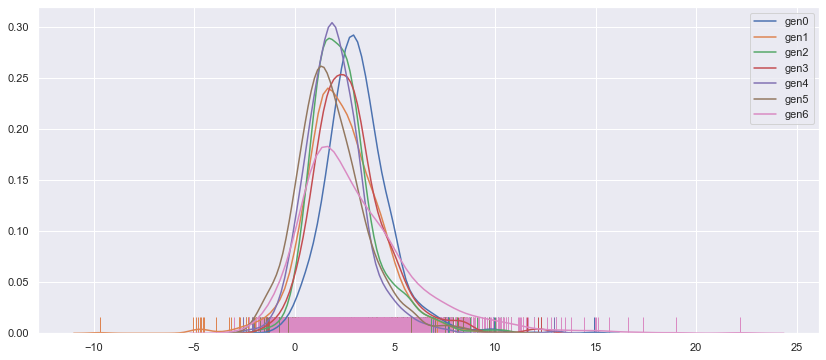

In [153]:
# Sort the dataframe by target
plt.figure(figsize=(14,6))

gen0_dist = final.loc[final['gen'] == 0]
gen1_dist = final.loc[final['gen'] == 1]
gen2_dist = final.loc[final['gen'] == 2]
gen3_dist = final.loc[final['gen'] == 3]
gen4_dist = final.loc[final['gen'] == 4]
gen5_dist = final.loc[final['gen'] == 5]
gen6_dist = final.loc[final['gen'] == 6]
# gen7_dist = final.loc[final['gen'] == 7]
# gen8_dist = final.loc[final['gen'] == 8]
# gen9_dist = final.loc[final['gen'] == 9]
# gen10_dist = final.loc[final['gen'] == 10]



sns.distplot(gen0_dist[['logp']], hist=False, rug=True, label="gen0")
sns.distplot(gen1_dist[['logp']], hist=False, rug=True, label="gen1")
sns.distplot(gen2_dist[['logp']], hist=False, rug=True, label="gen2")
sns.distplot(gen3_dist[['logp']], hist=False, rug=True, label="gen3")
sns.distplot(gen4_dist[['logp']], hist=False, rug=True, label="gen4")
sns.distplot(gen5_dist[['logp']], hist=False, rug=True, label="gen5")
sns.distplot(gen6_dist[['logp']], hist=False, rug=True, label="gen6")
# sns.distplot(gen7_dist[['logp']], hist=False, rug=True, label="gen7")
# sns.distplot(gen8_dist[['logp']], hist=False, rug=True, label="gen8")
# sns.distplot(gen9_dist[['logp']], hist=False, rug=True, label="gen9")
# sns.distplot(gen10_dist[['logp']], hist=False, rug=True, label="gen10")



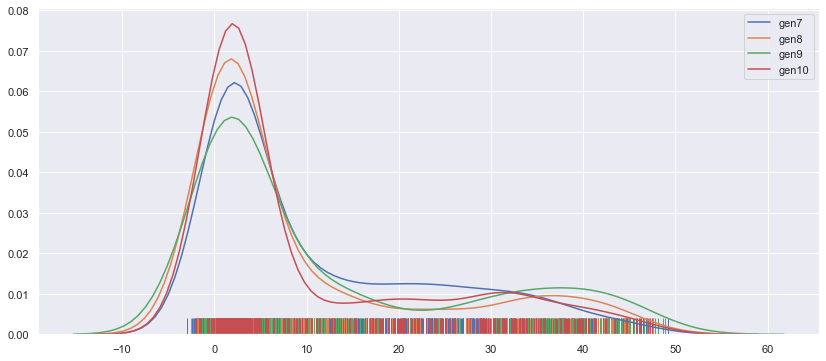

In [154]:
# Sort the dataframe by target
plt.figure(figsize=(14,6))

# gen0_dist = final.loc[final['gen'] == 0]
# gen1_dist = final.loc[final['gen'] == 1]
# gen2_dist = final.loc[final['gen'] == 2]
# gen3_dist = final.loc[final['gen'] == 3]
# gen4_dist = final.loc[final['gen'] == 4]
# gen5_dist = final.loc[final['gen'] == 5]
# gen6_dist = final.loc[final['gen'] == 6]
gen7_dist = final.loc[final['gen'] == 7]
gen8_dist = final.loc[final['gen'] == 8]
gen9_dist = final.loc[final['gen'] == 9]
gen10_dist = final.loc[final['gen'] == 10]



# sns.distplot(gen0_dist[['logp']], hist=False, rug=True, label="gen0")
# sns.distplot(gen1_dist[['logp']], hist=False, rug=True, label="gen1")
# sns.distplot(gen2_dist[['logp']], hist=False, rug=True, label="gen2")
# sns.distplot(gen3_dist[['logp']], hist=False, rug=True, label="gen3")
# sns.distplot(gen4_dist[['logp']], hist=False, rug=True, label="gen4")
# sns.distplot(gen5_dist[['logp']], hist=False, rug=True, label="gen5")
# sns.distplot(gen6_dist[['logp']], hist=False, rug=True, label="gen6")
sns.distplot(gen7_dist[['logp']], hist=False, rug=True, label="gen7")
sns.distplot(gen8_dist[['logp']], hist=False, rug=True, label="gen8")
sns.distplot(gen9_dist[['logp']], hist=False, rug=True, label="gen9")
sns.distplot(gen10_dist[['logp']], hist=False, rug=True, label="gen10")



### Correlations between attributes

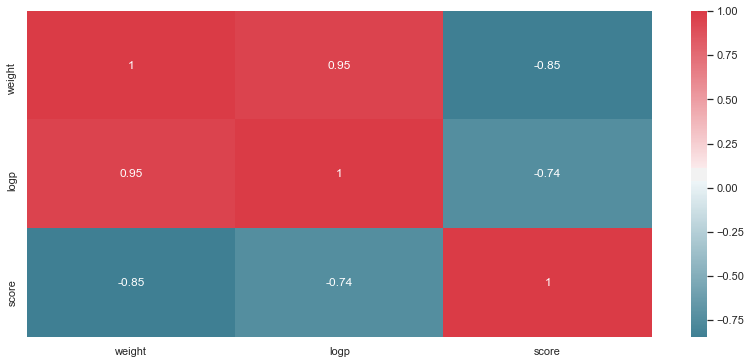

In [157]:
plt.figure(figsize=(14,6))
corr = final.loc[:,final.dtypes == 'float64'].corr()
sns.heatmap(corr, xticklabels=corr.columns, annot=True, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

### Violin Plot

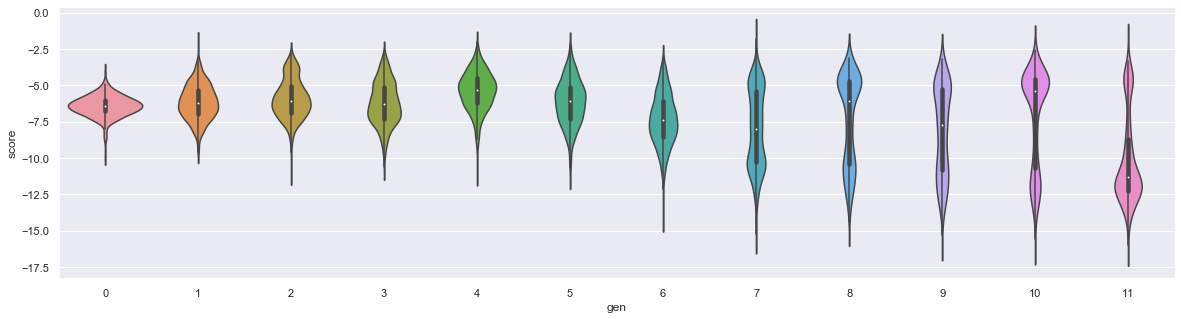

In [158]:
plt.figure(figsize=(20,5))
sns.violinplot(x="gen", y="score", data=final)


### KDE jointplot 

<Figure size 1440x360 with 0 Axes>

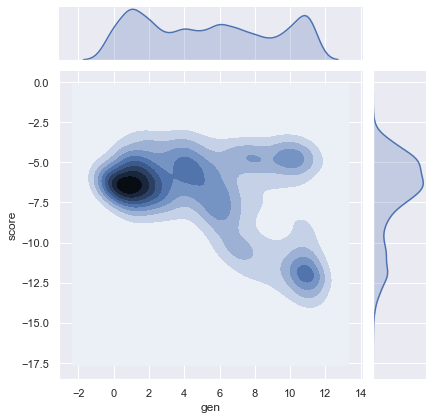

In [161]:
plt.figure(figsize=(20,5))

sns.jointplot(x="gen", y="score", data=final, kind="kde")